# 라이브러리 로드 및 데이터 로드

In [1]:
# 맞춤법 검사 라이브러리 py-hanspell
# # !pip install git+https://github.com/ssut/py-hanspell.git

In [2]:
# 라이브러리 로드
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

# 전처리
import re
from hanspell import spell_checker
from tqdm import tqdm
from konlpy.tag import Okt
from collections import Counter

# 바이너리 파일 저장 및 로드
import pickle

In [3]:
# 데이터셋 로드
# root_dir = "data"

# df = pd.read_parquet(f"{root_dir}/all_append_csv_12_26_1200i.gzip")
# display(df.head())
# df.shape

In [4]:
# 발라드만 떼오기
# df_ballad = df[df["장르"] == "발라드"].copy()
# df_ballad.shape

In [5]:
# 현재 경로 확인
%pwd

'C:\\Users\\JongHyun_Moon\\Jupyter_Python\\LikeLion\\project\\eda'

In [6]:
# 디렉토리 이동
%cd ..

C:\Users\JongHyun_Moon\Jupyter_Python\LikeLion\project


In [7]:
%pwd

'C:\\Users\\JongHyun_Moon\\Jupyter_Python\\LikeLion\\project'

In [8]:
root_dir = "data/data_ballad"
df_ballad = pd.read_csv(f"{root_dir}/melon_ballad_1_15000.csv", parse_dates=["발매일"])
display(df_ballad.head())
df_ballad.shape

,제목,가사,가수,발매일,좋아요수,장르
0,Monologue,다 잊었다는 거짓말\r\n또 해 버렸죠\r\n내 마음에 그대란 사람\r\n없다고 했...,테이,2022.09.18,"66,062",발라드
1,너의 모든 순간,이윽고 내가 한눈에\r\n너를 알아봤을 때\r\n모든 건 분명 달라지고 있었어\r\...,성시경,2014.02.12,"243,092","발라드, 국내드라마"
2,잘가요,미안해 마요 이제야 난 깨달아요\r\n내 절대 그대 짝이 아님을\r\n괜찮을게요 영...,주호,2022.12.04,"18,702",발라드
3,사랑은 늘 도망가,눈물이 난다 이 길을 걸으면\r\n그 사람 손길이 자꾸 생각이 난다\r\n붙잡지 못...,임영웅,2021.10.11,"185,585","발라드, 국내드라마"
4,해요 (2022),그녀와 나는요 그땐 참 어렸어요\r\n많이 사랑했고 때론 많이 다퉜었죠\r\n지금 ...,#안녕,2022.06.07,"63,808","발라드, 인디음악"


(13346, 6)

# 컬럼 전처리

## 데이터 타입 변경

In [9]:
# info
df_ballad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13346 entries, 0 to 13345
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제목      13346 non-null  object
 1   가사      13346 non-null  object
 2   가수      13346 non-null  object
 3   발매일     13346 non-null  object
 4   좋아요수    13346 non-null  object
 5   장르      13346 non-null  object
dtypes: object(6)
memory usage: 625.7+ KB


In [10]:
# 발매일 없는 데이터는 na로 처리
df_ballad["발매일"] = pd.to_datetime(df_ballad["발매일"], errors="coerce")

# 발매일 없는 데이터는 채울까 ? drop 할까?
df_ballad = df_ballad.dropna(subset=["발매일"])

In [11]:
# 좋아요 수 int 타입으로 변경 -> concat할 때 처리함
df_ballad["좋아요수"] = df_ballad["좋아요수"].str.replace(",", "")
df_ballad["좋아요수"] = df_ballad["좋아요수"].astype(int)

In [12]:
# info
df_ballad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13340 entries, 0 to 13345
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   제목      13340 non-null  object        
 1   가사      13340 non-null  object        
 2   가수      13340 non-null  object        
 3   발매일     13340 non-null  datetime64[ns]
 4   좋아요수    13340 non-null  int32         
 5   장르      13340 non-null  object        
dtypes: datetime64[ns](1), int32(1), object(4)
memory usage: 677.4+ KB


## 장르 구분

In [13]:
# 장르 구분
genre_split = df_ballad["장르"].str.split(",")
df_ballad["장르1"] = genre_split.str.get(0)
df_ballad["장르2"] = genre_split.str.get(1)
df_ballad["장르3"] = genre_split.str.get(2)
df_ballad["장르4"] = genre_split.str.get(3)

In [14]:
# 장르 분포 확인
# 장르는 한 곡에 최대 4개까지 있으나 양이 적어서 필요한 컬럼만 사용
display(df_ballad["장르1"].value_counts())
print("-"*30)
display(df_ballad["장르2"].value_counts())
print("-"*30)
display(df_ballad["장르3"].value_counts())
print("-"*30)
display(df_ballad["장르4"].value_counts())

발라드    13340
Name: 장르1, dtype: int64

------------------------------


 국내드라마       2381
 인디음악        1165
 국내영화          85
 애니메이션/웹툰      81
 R&B/Soul      71
 랩/힙합          41
 록/메탈          33
 게임            16
 포크/블루스        10
 성인가요/트로트       8
 댄스             5
 국외영화           5
Name: 장르2, dtype: int64

------------------------------


 국내드라마       68
 포크/블루스       4
 키즈           3
 랩/힙합         1
 애니메이션/웹툰     1
 국내영화         1
Name: 장르3, dtype: int64

------------------------------


 만화    3
Name: 장르4, dtype: int64

## 날짜, 요일 추가
* 일단 다각면에서 분석하고자 다 만들어두긴 했으나.. 연도와 월 빼고는 쓸모가 없을 듯 싶다

In [15]:
# 날짜, 요일 추가
df_ballad["년"] = df_ballad["발매일"].dt.year
df_ballad["월"] = df_ballad["발매일"].dt.month
# df_ballad["일"] = df_ballad["발매일"].dt.day
# df_ballad["요일"] = df_ballad["발매일"].dt.dayofweek

In [16]:
# 계절 추가
df_ballad.loc[df_ballad["월"].isin([12,1,2]), "계절"] = "겨울"
df_ballad.loc[df_ballad["월"].isin([3,4,5]), "계절"] = "봄"
df_ballad.loc[df_ballad["월"].isin([6,7,8]), "계절"] = "여름"
df_ballad.loc[df_ballad["월"].isin([9,10,11]), "계절"] = "가을"

In [17]:
# 연도별 노래 개수
df_ballad["년"].value_counts()

2022    2123
2021    1358
2020     998
2019     859
2018     802
2017     696
2016     691
2015     498
2014     483
2012     462
2010     447
2011     439
2013     403
2008     383
2009     321
2007     311
2006     258
2004     252
2005     206
2002     195
2003     168
2001     146
2000     120
1999      95
1998      87
1997      70
1996      65
1989      53
1995      44
1992      43
1987      42
1994      42
1990      37
1988      31
1991      31
1993      28
1985      21
1986      10
1983       5
1978       5
1980       4
1979       3
1984       3
1982       1
1981       1
Name: 년, dtype: int64

In [18]:
# 계절별 노래 개수
df_ballad["계절"].value_counts()

가을    4079
겨울    3662
봄     3028
여름    2571
Name: 계절, dtype: int64

In [19]:
df_ballad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13340 entries, 0 to 13345
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   제목      13340 non-null  object        
 1   가사      13340 non-null  object        
 2   가수      13340 non-null  object        
 3   발매일     13340 non-null  datetime64[ns]
 4   좋아요수    13340 non-null  int32         
 5   장르      13340 non-null  object        
 6   장르1     13340 non-null  object        
 7   장르2     3901 non-null   object        
 8   장르3     78 non-null     object        
 9   장르4     3 non-null      object        
 10  년       13340 non-null  int64         
 11  월       13340 non-null  int64         
 12  계절      13340 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(2), object(9)
memory usage: 1.4+ MB


# EDA

## 중복행 제거

In [20]:
# 중복행 한 번 더 확인
df_ballad[df_ballad.duplicated(keep=False)]

,제목,가사,가수,발매일,좋아요수,장르,장르1,장르2,장르3,장르4,년,월,계절
6531,Goodbye To Romance(민서 X 김이나 프로젝트) (Inst.),It's time for goodbye\r\n나의 로맨스여 Goodbye\r\n바로...,민서 (MINSEO),2022-12-26,11,발라드,발라드,NaN,NaN,NaN,2022,12,겨울
7889,욕심,너무 늦어버린걸 이미 알고 있어 난\r\n괜히 또 괜찮은 척 웃고있어\r\n바쁜 하...,성민,2022-08-30,85,발라드,발라드,NaN,NaN,NaN,2022,8,여름
7970,소낙눈,보석처럼 빛나는 아침\r\n단비 같은 눈이 내렸어\r\n눈부시던 창 밖 풍경에\r\...,소낙별,2017-01-24,225,발라드,발라드,NaN,NaN,NaN,2017,1,겨울
8028,기억을 걷다,참 많이도 웃었지\r\n숨 쉬듯 내 곁에 있었지\r\n편안했었고 친절했었지\r\n그...,정승환,2015-04-05,7550,발라드,발라드,NaN,NaN,NaN,2015,4,봄
8151,백허그 (Back Hug),백허그 (Back Hug)\r\n\r\n가만히 뒤에서 날 끌어안아줘\r\n내 어깨에...,소녀시대 (GIRLS' GENERATION),2014-02-24,8623,발라드,발라드,NaN,NaN,NaN,2014,2,겨울
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11211,견뎌야 하는 우리에게,문득 생각을 해봤어\r\n지난날 우린 누구보다\r\n뜨겁고 미친 듯이 사랑했고\r\...,먼데이 키즈 (Monday Kiz),2020-05-20,3000,발라드,발라드,NaN,NaN,NaN,2020,5,봄
11220,우리들의 겨울이야기 (feat.뮤시아),나 오랫동안 준비해 왔던\r\n그 말을 전할 때가 온 거야\r\n그대가 좋아하는 하...,EQ,2022-12-21,27,"발라드, 인디음악",발라드,인디음악,NaN,NaN,2022,12,겨울
11515,Hate Christmas,우 모두 기다렸던\r\n메리 크리스마스\r\n홀로 쓸쓸한 이 밤\r\n설레는 예쁜 ...,임도혁,2016-12-21,450,발라드,발라드,NaN,NaN,NaN,2016,12,겨울
11532,후회 (Original ver.),아무렇지 않은 척했네\r\n그대 떠난 자리에 서서\r\n슬퍼하지 않으려 했네\r\n...,범진,2022-02-28,271,"발라드, 인디음악",발라드,인디음악,NaN,NaN,2022,2,겨울


In [21]:
# 중복행 drop
print(df_ballad.shape)
df_ballad = df_ballad.drop_duplicates()
df_ballad.shape

(13340, 13)


(13124, 13)

## 가사 전처리

In [22]:
# 필요 없는 단어 제거
df_ballad["가사"] = df_ballad["가사"].map(lambda x : re.sub("1절", "", x))
df_ballad["가사"] = df_ballad["가사"].map(lambda x : re.sub("2절", "", x))
df_ballad["가사"] = df_ballad["가사"].map(lambda x : re.sub("브리지", "", x).strip())

In [23]:
# 이외 기본적인 전처리
df_ballad["가사"] = df_ballad["가사"].map(lambda x : re.sub("\s{2,}", " ", x)) # 공백 2회 이상 제거
df_ballad["가사"] = df_ballad["가사"].map(lambda x : re.sub("\n", " ", x)) # 개행문자 제거

## 시각화

### 가수별 분석

In [24]:
# 가수별 곡 수
df_singer_soundtrack = df_ballad.groupby("가수").agg({"제목" : "count", 
                                                 "좋아요수" : "sum"}).sort_values("제목", ascending=False).reset_index()

# 가수별 좋아요 수
df_singer_like = df_ballad.groupby("가수").agg({"제목" : "count", 
                                                 "좋아요수" : "sum"}).sort_values("좋아요수", ascending=False).reset_index()
display(df_singer_soundtrack.head())
df_singer_like.head()

,가수,제목,좋아요수
0,먼데이 키즈 (Monday Kiz),130,1250007
1,성시경,129,2461336
2,엠씨더맥스 (M.C the MAX),127,2298255
3,지아,109,802739
4,임창정,109,1733212


,가수,제목,좋아요수
0,아이유,75,5405204
1,태연 (TAEYEON),54,2633545
2,박효신,90,2484356
3,성시경,129,2461336
4,엠씨더맥스 (M.C the MAX),127,2298255


<AxesSubplot: xlabel='제목', ylabel='가수'>

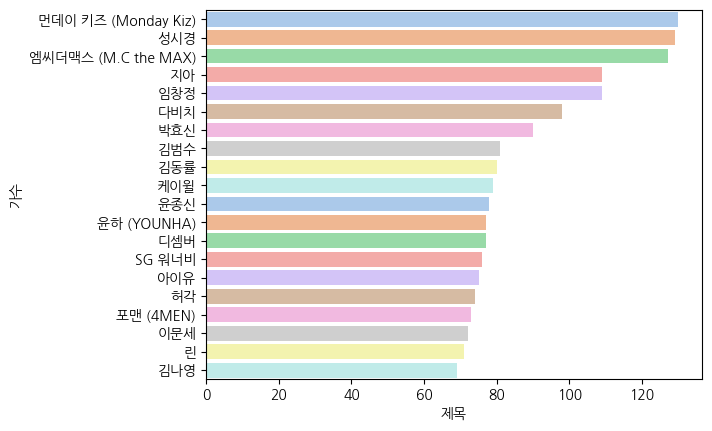

In [25]:
# 곡 수 top 20 시각화
sns.barplot(df_singer_soundtrack[:20], x="제목", y="가수", palette = sns.color_palette("pastel"))

<AxesSubplot: xlabel='좋아요수', ylabel='가수'>

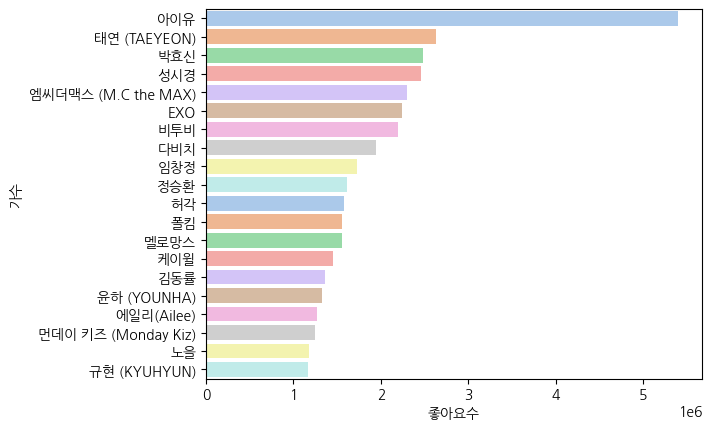

In [26]:
# 좋아요 수 top 20 시각화
sns.barplot(df_singer_like[:20], x="좋아요수", y="가수", palette = sns.color_palette("pastel"))

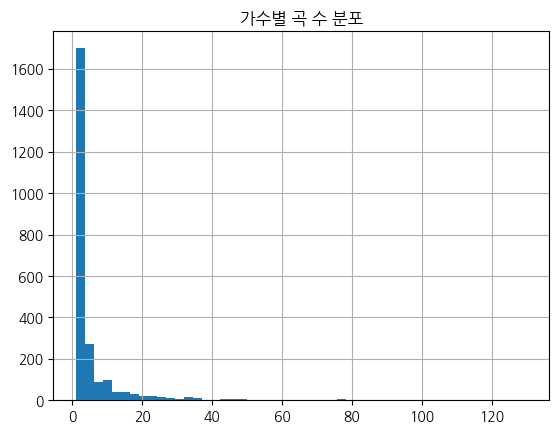

In [27]:
# 가수별 곡 수의 분포
df_singer_soundtrack["제목"].hist(bins=50).set_title("가수별 곡 수 분포");

- 인기순에 노래가 많이 오른 가수들의 노래는 대중들로부터 인정을 받았다고 볼 수 있기 때문에 이 곡들의 가사로 학습해봐도 괜찮지 않을까?
- 혹은 음악의 좋아요 수가 많은 가수들의 노래?
- 이 두 가지를 혼합한 기준?

### 연도별 분석

<AxesSubplot: xlabel='년', ylabel='제목'>

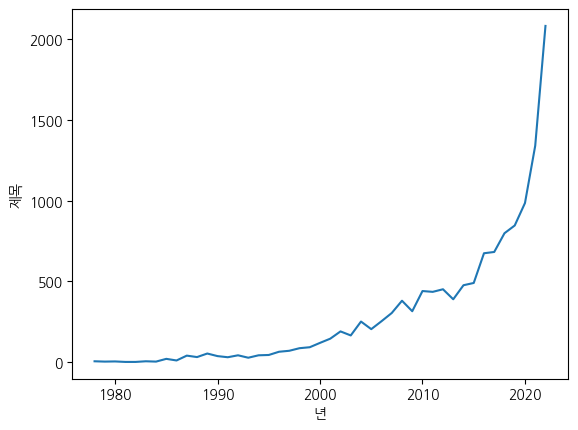

In [28]:
# 연도별 인기순 데이터
sns.lineplot(data=df_ballad.groupby("년")[["제목"]].count().reset_index(), x="년", y="제목")

- 발라드 장르 "최신곡"의 인기순 정렬이다보니 최신으로 갈수록 데이터가 많아짐(1~15000곡 기준)

### 곡별 가사 길이 분포

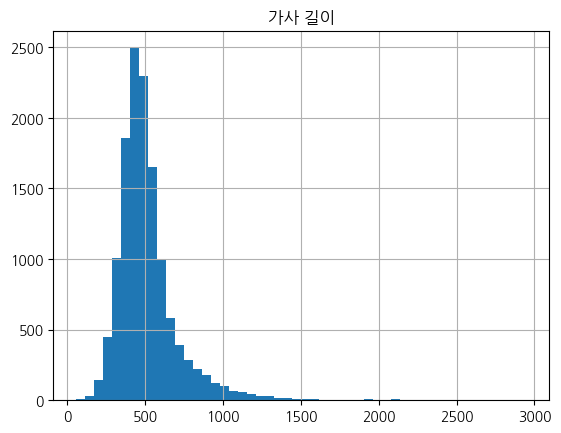

In [29]:
# 가사 길이 분포
df_ballad["가사"].str.len().hist(bins=50).set_title("가사 길이");

- 공백 포함 약 300~600자 사이에 가장 많이 분포함
- 가사 전처리를 러프하게 했기 때문에 실제 가사 길이와 오차는 있을 수 있음(특수문자 등)

## 맞춤법 검사기 활용 -> 사용 x
- 네이버 맞춤법 검사기 기반의 `py-hanspell` 라이브러리 사용
- 네이버 맞춤법 검사기 기반이기 때문에 500자가 넘어가면 사용하지 못하므로 문장 단위로 끊어서 사용해야함
- 사용하게 된다면 모델에 input할 가사만 맞춤법 검사해도 될듯
- 형태소 분석기 사용 시 띄어쓰기 처리 알아서 끊어주기 때문에 사용 x

In [30]:
# spell_checker()

## 가사 형태소 분석

In [31]:
# 형태소 분석기 호출 및 함수 정의
okt = Okt()
def okt_clean(text):
    clean_text = []
    # 품사 태깅 후 태깅 결과를 받아서 순회 
    for word in okt.pos(text, norm=True, stem=True):
        # 품사가 구두점이면 제외하고 append 로 인덱스 0번 값만 다시 리스트에 담아줌
        if word[1] not in 'Punctuation':
            clean_text.append(word[0])
    # 공백 문자로 연결
    return " ".join(clean_text)

In [32]:
# 판다스에서 tqdm 기능 사용하기 위해 선언
tqdm.pandas()

In [33]:
# 모든 가사에 적용
# df_ballad["가사_전처리"] = df_ballad["가사"].progress_map(okt_clean)

### 계절별 분석
- 사랑에 미쳐버린 노래들..
- 계절별로 노래 가사 단어 빈도의 뚜렷한 차이는 발견하지 못했음

In [ ]:
# 각 계절별 좋아요수 상위 20개 추출
df_ballad_spring = df_ballad[df_ballad["계절"] == "봄"].sort_values("좋아요수", ascending=False).head(50)
df_ballad_summer = df_ballad[df_ballad["계절"] == "여름"].sort_values("좋아요수", ascending=False).head(50)
df_ballad_fall = df_ballad[df_ballad["계절"] == "가을"].sort_values("좋아요수", ascending=False).head(50)
df_ballad_winter = df_ballad[df_ballad["계절"] == "겨울"].sort_values("좋아요수", ascending=False).head(50)

In [ ]:
# 하나의 문자열로 추출
lyrics_spring = ' '.join(df_ballad_spring["가사"])
lyrics_summer = ' '.join(df_ballad_summer["가사"])
lyrics_fall = ' '.join(df_ballad_fall["가사"])
lyrics_winter = ' '.join(df_ballad_winter["가사"])

In [ ]:
# 봄 빈도수 상위 30개 명사 추출(너, 나, 내 같이 의미없는 한 자 단어가 많아서 한글자는 제외함)
lyrics_spring_noun = okt.nouns(lyrics_spring)
count_spring = Counter(lyrics_spring_noun)
count_spring_dict = dict(count_spring.most_common(100))
count_spring_df = pd.DataFrame(count_spring_dict.values(), count_spring_dict.keys())
count_spring_df = count_spring_df.reset_index()
count_spring_df.columns = ["단어", "빈도"]
count_spring_df = count_spring_df[count_spring_df["단어"].str.len() != 1].head(30)

In [ ]:
# 봄 시각화
plt.figure(figsize=(12,10))
plt.title("봄에 출시된 노래의 가사 단어 빈도수")
sns.barplot(data=count_spring_df, x="빈도", y="단어", palette = sns.color_palette("pastel"));

In [ ]:
lyrics_summer_noun = okt.nouns(lyrics_summer)
count_summer = Counter(lyrics_summer_noun)
count_summer_dict = dict(count_summer.most_common(100))
count_summer_df = pd.DataFrame(count_summer_dict.values(), count_summer_dict.keys())
count_summer_df = count_summer_df.reset_index()
count_summer_df.columns = ["단어", "빈도"]
count_summer_df = count_summer_df[count_summer_df["단어"].str.len() != 1].head(30)

In [ ]:
# 여름 시각화
plt.figure(figsize=(12,10))
plt.title("여름에 출시된 노래의 가사 단어 빈도수")
sns.barplot(data=count_summer_df, x="빈도", y="단어", palette = sns.color_palette("pastel"));

In [ ]:
lyrics_fall_noun = okt.nouns(lyrics_fall)
count_fall = Counter(lyrics_fall_noun)
count_fall_dict = dict(count_fall.most_common(100))
count_fall_df = pd.DataFrame(count_fall_dict.values(), count_fall_dict.keys())
count_fall_df = count_fall_df.reset_index()
count_fall_df.columns = ["단어", "빈도"]
count_fall_df = count_fall_df[count_fall_df["단어"].str.len() != 1].head(30)

In [ ]:
# 가을 시각화
plt.figure(figsize=(12,10))
plt.title("가을에 출시된 노래의 가사 단어 빈도수")
sns.barplot(data=count_fall_df, x="빈도", y="단어", palette = sns.color_palette("pastel"));

In [ ]:
lyrics_winter_noun = okt.nouns(lyrics_winter)
count_winter = Counter(lyrics_winter_noun)
count_winter_dict = dict(count_winter.most_common(100))
count_winter_df = pd.DataFrame(count_winter_dict.values(), count_winter_dict.keys())
count_winter_df = count_winter_df.reset_index()
count_winter_df.columns = ["단어", "빈도"]
count_winter_df = count_winter_df[count_winter_df["단어"].str.len() != 1].head(30)

In [ ]:
# 겨울 시각화
plt.figure(figsize=(12,10))
plt.title("겨울에 출시된 노래의 가사 단어 빈도수")
sns.barplot(data=count_fall_df, x="빈도", y="단어", palette = sns.color_palette("pastel"));

# 모델 input을 위한 전처리

In [ ]:
# 가사에 개행문자 없는 데이터 제거
# df_ballad = df_ballad[df_ballad["가사"].str.contains("\n")]

In [ ]:
# 기본 전처리
# df_ballad["가사"] = df_ballad["가사"].map(lambda x : re.sub("[^ㄱ-ㅎ가-힣0-9\n ]", "", x).strip()) # 한글 자음, 한글, 숫자, 개행문자만 남기고 제거
# df_ballad["가사"] = df_ballad["가사"].map(lambda x : re.sub("\s{2,}", "", x)) # 공백 2회 이상 제거
# df_ballad = df_ballad[df_ballad["가사"].map(lambda x : len(x) > 10)] # 전처리 후 빈 행이나 10자 이상이 안되는 데이터 제거
# df_ballad = df_ballad.reset_index(drop=True) # 인덱스 초기화
# df_ballad.shape